# **Feature Extraction from the entire Original Dataset.**

*General*
*   Original Sample Rate - **48000Hz**, should resample to -> **600Hz** Sample Rate
*   This is used for the **classification module** training.
*   No beamforming based stereo to mono conversion is needed for this since the dataset is already in mono format.
*   The audio files are segmented to **2s** duration.
*   Each data is processed with **1s** with overlapping of **0.6s** shift.


*About the dataset*

*   104 positive and 110 negative samples for training
*   75 positive and 100 negative samples for testing 

*Number of overlapping frames in a given audio file(2s) -> 4*

*   duration = 2s = 2000ms
*   frame length = 1s = 1000ms
*   overlap = 0.6s = 600ms

2000=1000n−600(n−1) 

1400=400n

**n=3.5 ~ 4**


># **Implementation** 🔽



# **Pre-Processing Module**
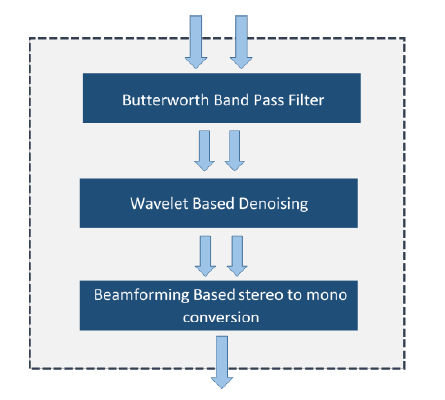

**Butterworth Band Pass Filter**

Filtering the signal's frequency range between 10Hz and 150Hz.

In [1]:
import librosa
from scipy.signal import butter, lfilter, filtfilt

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz
import os

def butter_bandpass(lowcut, highcut, FRAME_RATE, order):
    nyq = 0.5 * FRAME_RATE
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, FRAME_RATE, order):
    b, a = butter_bandpass(lowcut, highcut, FRAME_RATE, order)
    # y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y

lowcut = 10.0
highcut = 150.0
FRAME_RATE = 600
order = 9

**Wevelet Based Denoising**

Further denoising the filtered audio signal.

In [2]:
from skimage.restoration import denoise_wavelet

# denoise_signal = [] 

# for x in filtered_signal :

#   x_denoise = denoise_wavelet(x, method = 'VisuShrink', mode = 'soft', wavelet_levels = 3, wavelet = 'db3', rescale_sigma = 'True')
#   denoise_signal.append(x_denoise)


# **Feature Extraction Module**
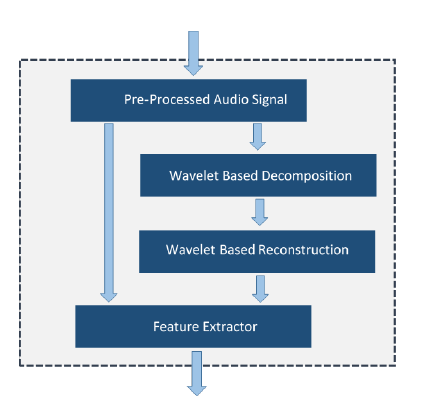

**Wavelet Decomposition & Reconstruction**

Altogether 8 signal variations including the original one.

row, all_recon, rm_approx, rm_approx_cd1, cA3, cd3, cd2, cd1

In [3]:
def wavelet_reconstructor(signal, wavelet_name, decomposition_level):
  reconstructed_signal = {}

  # row signal
  # reconstructed_signal.append(signal)
  reconstructed_signal['row'] = signal

  coeffs = pywt.wavedec(signal, wavelet_name, level=decomposition_level)
  backup = copy.deepcopy(coeffs)
  # reconstructed signal with all sub-bands
  # reconstructed_signal.append(pywt.waverec(coeffs,wavelet_name))

  reconstructed_signal['all_recon'] = pywt.waverec(coeffs,wavelet_name)
  # with out approximate sub-band
  coeffs[-4] = np.zeros_like(coeffs[-4])

  # reconstructed_signal.append(pywt.waverec(coeffs,wavelet_name))
  reconstructed_signal['rm_approx'] = pywt.waverec(coeffs,wavelet_name)

  # with out approximate and level - 1 sub-band
  # coeffs[-4] = np.zeros_like(coeffs[-4])
  coeffs[-1] = np.zeros_like(coeffs[-1])
  # reconstructed_signal.append(pywt.waverec(coeffs,wavelet_name))
  reconstructed_signal['rm_approx_cd1'] = pywt.waverec(coeffs,wavelet_name)

  # single sub-bands
  # only level 3 approximate coefficient
  coeffs = copy.deepcopy(backup)
  coeffs[-1] = np.zeros_like(coeffs[-1])
  coeffs[-2] = np.zeros_like(coeffs[-2])
  coeffs[-3] = np.zeros_like(coeffs[-3])
  # reconstructed_signal.append(pywt.waverec(coeffs,wavelet_name))
  reconstructed_signal['cA3'] = pywt.waverec(coeffs,wavelet_name)

  # only level 3 detailed coefficient
  coeffs = copy.deepcopy(backup)
  coeffs[-1] = np.zeros_like(coeffs[-1])
  coeffs[-2] = np.zeros_like(coeffs[-2])
  coeffs[-4] = np.zeros_like(coeffs[-4])
  # reconstructed_signal.append(pywt.waverec(coeffs,wavelet_name))
  reconstructed_signal['cd3'] = pywt.waverec(coeffs,wavelet_name) 

  # only level 2 detailed coefficient
  coeffs = copy.deepcopy(backup)
  coeffs[-1] = np.zeros_like(coeffs[-1])
  coeffs[-3] = np.zeros_like(coeffs[-3])
  coeffs[-4] = np.zeros_like(coeffs[-4])
  # reconstructed_signal.append(pywt.waverec(coeffs,wavelet_name))
  reconstructed_signal['cd2'] = pywt.waverec(coeffs,wavelet_name)

  # only level 1 detailed coefficient
  coeffs = copy.deepcopy(backup)
  coeffs[-2] = np.zeros_like(coeffs[-2])
  coeffs[-3] = np.zeros_like(coeffs[-3])
  coeffs[-4] = np.zeros_like(coeffs[-4])
  # reconstructed_signal.append(pywt.waverec(coeffs,wavelet_name))
  reconstructed_signal['cd1'] = pywt.waverec(coeffs,wavelet_name)

  return reconstructed_signal


**Feature Extraction**

84 (Number of values per frame) x 8(signal variations) = 672 total features for a frame

In [4]:
def feature_divider(feature_vector, feature_name,final_feature_vector, feature_class, siganl_type):
  # check if final_feature_vector empty or not
  if not final_feature_vector:

    for n in range(len(feature_vector[0])):
       final_feature_vector.append({'feature_class': feature_class})

  frame_count = len(final_feature_vector)
  for feature in range(len(feature_vector)):
        # print (feature_vector)
          for frame in range(frame_count):
            name = str(feature_name) + " - " + str(feature) + " - " + str(siganl_type)
            current_frame = final_feature_vector[frame]
            current_frame[name] = feature_vector[feature][frame]
       

In [5]:
def extract_features(signal,siganl_type, sample_rate, frame_length,hop_length, feature_class,final_feature_vector):
  zeroCrossingRate = librosa.feature.zero_crossing_rate(y=signal, frame_length=frame_length, hop_length=hop_length)
  # print ("zeroCrossingRate", zeroCrossingRate)
  feature_divider(zeroCrossingRate, "zero_crossing_rate",final_feature_vector, feature_class, siganl_type)

  chromaStft = librosa.feature.chroma_stft(y=signal, sr=sample_rate, tuning=0.3, n_fft=frame_length, hop_length=hop_length)
  # print ("chromaStft", chromaStft) # tuning
  feature_divider(chromaStft, "chroma_stft",final_feature_vector, feature_class, siganl_type)

  chromaCqt = librosa.feature.chroma_cqt(y=signal, fmin=10,n_octaves=3, sr=sample_rate, hop_length=hop_length)
  # print ("chromaCqt", chromaCqt) # fmin and n_octaves
  feature_divider(chromaCqt, "chroma_cqt", final_feature_vector, feature_class, siganl_type)

  chromaCens = librosa.feature.chroma_cens(y=signal, fmin=10,n_octaves=3, sr=sample_rate, hop_length=hop_length)
  # print ("chromaCens", chromaCens)
  feature_divider(chromaCens, "chroma_cens",final_feature_vector, feature_class, siganl_type)

  melspectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=30, fmin=10, fmax=150, n_fft=frame_length, hop_length=hop_length)
  # print ("melspectrogram", melspectrogram)
  feature_divider(melspectrogram, "melspectrogram",final_feature_vector, feature_class, siganl_type)

  mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=5, n_mels=30, fmin=10, fmax=150, n_fft=frame_length,hop_length=hop_length)
  # print ("mfcc", mfcc)
  feature_divider(mfcc, "mfcc", final_feature_vector,feature_class, siganl_type)

  rmse = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)
  # print ("rmse", rmse)
  feature_divider(rmse, "rmse", final_feature_vector,feature_class, siganl_type)

  spectralCentroid = librosa.feature.spectral_centroid(y=signal, sr=sample_rate, n_fft=frame_length, hop_length=hop_length)
  # print ("spectralCentroid", spectralCentroid)
  feature_divider(spectralCentroid, "spectral_centroid",final_feature_vector, feature_class, siganl_type)

  spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sample_rate,n_fft=frame_length, hop_length=hop_length)
  # print ("spectral_bandwidth", spectral_bandwidth)
  feature_divider(spectral_bandwidth, "spectral_bandwidth",final_feature_vector, feature_class, siganl_type)

  spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate, n_fft=frame_length, hop_length=hop_length, fmin=5,n_bands=5)
  # print ("spectral_contrast", spectral_contrast)
  feature_divider(spectral_contrast, "spectral_contrast",final_feature_vector, feature_class, siganl_type)

  spectral_rolloff = librosa.feature.spectral_rolloff(y=signal,sr=sample_rate, n_fft=frame_length, hop_length=hop_length,roll_percent=0.85)
  # print ("spectral_rolloff", spectral_rolloff) #roll_percent
  feature_divider(spectral_rolloff, "spectral_rolloff",final_feature_vector, feature_class, siganl_type)

  poly_features = librosa.feature.poly_features(y=signal, sr=sample_rate, n_fft=frame_length, hop_length=hop_length,order=1)
  # print ("poly_features", poly_features)
  feature_divider(poly_features, "poly_features",final_feature_vector, feature_class, siganl_type)

In [6]:
def extract_features_all_signal_type(signal_array,sample_rate,frame_length, hop_length, feature_class):
  final_feature_vector = []

  no_of_frame_in_row_signal = len(signal_array['row'])
  for key in signal_array.keys():

  # after the reconnecting it will change the total number ofsamples by +/- 1 .
  # This will lead to diffenet number of frames in given signals.
  # to overcome this all recontacted signal length limit to the same size of row signal
    signal = signal_array[key][:no_of_frame_in_row_signal]

    extract_features(signal, key, sample_rate, frame_length,hop_length, feature_class, final_feature_vector)

  return final_feature_vector

In [7]:
import librosa
import pywt
import copy
import numpy as np
import pandas as pd  

wavelet_name ='db3'
frame_length = 600 #1s x sample rate
hop_length = 360 #0.6s x sample rate
signal_array = []
features1 = [] #rumbles 
features0 = [] #other

In [8]:
#Rumbles
pathAudio1 = "/content/drive/MyDrive/ELOC-SW/new dataset with nature sounds/rumbles-original-2secs" 
files1 = librosa.util.find_files(pathAudio1, ext=['wav']) 
files1 = np.asarray(files1)
for y in files1: 
    data, sr = librosa.load(y,sr=600)
    b = butter_bandpass_filter(data, lowcut, highcut, FRAME_RATE, order)
    x_denoise = denoise_wavelet(b, method = 'VisuShrink', mode = 'soft', wavelet_levels = 3, wavelet = 'db3', rescale_sigma = 'True')
    signal = wavelet_reconstructor( x_denoise, wavelet_name, 3)
    p = extract_features_all_signal_type(signal,600,frame_length,hop_length, 1)
    features1.append(p)

#Other
pathAudio2 = "/content/drive/MyDrive/ELOC-SW/new dataset with nature sounds/other-original-2secs"
files0 = librosa.util.find_files(pathAudio2, ext=['wav']) 
files0 = np.asarray(files0)
for z in files0: 
    data, sr = librosa.load(z,sr=600)
    b = butter_bandpass_filter(data, lowcut, highcut, FRAME_RATE, order)
    x_denoise = denoise_wavelet(b, method = 'VisuShrink', mode = 'soft', wavelet_levels = 3, wavelet = 'db3', rescale_sigma = 'True')
    signal = wavelet_reconstructor( x_denoise, wavelet_name, 3)
    p = extract_features_all_signal_type(signal,600,frame_length,hop_length, 0)
    features0.append(p)



/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1200
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=600
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=300
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1200
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estima

In [9]:
features_combined = np.concatenate((features1, features0))

from itertools import chain

df = pd.DataFrame(list(chain.from_iterable(features_combined)))
df.to_csv('/content/drive/MyDrive/ELOC-SW/features/features_original.csv', index=False) 
df

,feature_class,zero_crossing_rate - 0 - row,chroma_stft - 0 - row,chroma_stft - 1 - row,chroma_stft - 2 - row,chroma_stft - 3 - row,chroma_stft - 4 - row,chroma_stft - 5 - row,chroma_stft - 6 - row,chroma_stft - 7 - row,chroma_stft - 8 - row,chroma_stft - 9 - row,chroma_stft - 10 - row,chroma_stft - 11 - row,chroma_cqt - 0 - row,chroma_cqt - 1 - row,chroma_cqt - 2 - row,chroma_cqt - 3 - row,chroma_cqt - 4 - row,chroma_cqt - 5 - row,chroma_cqt - 6 - row,chroma_cqt - 7 - row,chroma_cqt - 8 - row,chroma_cqt - 9 - row,chroma_cqt - 10 - row,chroma_cqt - 11 - row,chroma_cens - 0 - row,chroma_cens - 1 - row,chroma_cens - 2 - row,chroma_cens - 3 - row,chroma_cens - 4 - row,chroma_cens - 5 - row,chroma_cens - 6 - row,chroma_cens - 7 - row,chroma_cens - 8 - row,chroma_cens - 9 - row,chroma_cens - 10 - row,chroma_cens - 11 - row,melspectrogram - 0 - row,melspectrogram - 1 - row,...,melspectrogram - 7 - cd1,melspectrogram - 8 - cd1,melspectrogram - 9 - cd1,melspectrogram - 10 - cd1,melspectrogram - 11 - cd1,melspectrogram - 12 - cd1,melspectrogram - 13 - cd1,melspectrogram - 14 - cd1,melspectrogram - 15 - cd1,melspectrogram - 16 - cd1,melspectrogram - 17 - cd1,melspectrogram - 18 - cd1,melspectrogram - 19 - cd1,melspectrogram - 20 - cd1,melspectrogram - 21 - cd1,melspectrogram - 22 - cd1,melspectrogram - 23 - cd1,melspectrogram - 24 - cd1,melspectrogram - 25 - cd1,melspectrogram - 26 - cd1,melspectrogram - 27 - cd1,melspectrogram - 28 - cd1,melspectrogram - 29 - cd1,mfcc - 0 - cd1,mfcc - 1 - cd1,mfcc - 2 - cd1,mfcc - 3 - cd1,mfcc - 4 - cd1,rmse - 0 - cd1,spectral_centroid - 0 - cd1,spectral_bandwidth - 0 - cd1,spectral_contrast - 0 - cd1,spectral_contrast - 1 - cd1,spectral_contrast - 2 - cd1,spectral_contrast - 3 - cd1,spectral_contrast - 4 - cd1,spectral_contrast - 5 - cd1,spectral_rolloff - 0 - cd1,poly_features - 0 - cd1,poly_features - 1 - cd1
0,1,0.036667,0.027315,0.064863,0.091160,0.080837,0.311170,0.561670,1.000000,0.787794,0.432896,0.063951,0.026873,0.042425,0.268634,0.190497,0.252820,0.414099,0.414560,1.000000,0.932159,0.823416,0.348228,0.366304,0.307330,0.146496,0.119442,0.000000,0.000000,0.237570,0.357012,0.591921,0.532703,0.299140,0.178352,0.178352,0.120788,0.000000,0.483933,4.533303,...,3.060275e-09,3.582024e-09,4.362631e-09,5.310534e-09,6.633415e-09,8.269482e-09,1.042788e-08,1.311285e-08,1.646706e-08,2.064142e-08,2.556336e-08,3.168906e-08,3.846353e-08,4.692491e-08,5.561935e-08,6.659603e-08,7.692751e-08,9.026572e-08,1.015064e-07,1.166251e-07,1.275890e-07,1.434573e-07,1.526000e-07,-428.956690,-36.953197,0.600343,-0.275013,0.690972,1.014270e-05,167.850326,62.542169,0.004394,0.019004,0.102065,0.696889,3.786557,17.610805,227.0,4.835141e-07,1.319807e-04
1,1,0.078333,0.236603,0.197802,0.096920,0.190529,0.575033,1.000000,0.996044,0.615724,0.281789,0.220250,0.114236,0.088693,0.298993,0.163514,0.227299,0.454225,0.684120,1.000000,0.530363,0.599188,0.299484,0.359870,0.273799,0.230509,0.119385,0.000000,0.000000,0.237440,0.356825,0.592935,0.533410,0.297300,0.177915,0.177915,0.119385,0.000000,3.950423,15.975969,...,4.377565e-07,1.141171e-07,1.315705e-07,1.695012e-06,6.481721e-06,9.248756e-06,5.293175e-06,2.473989e-06,9.988119e-06,3.245764e-05,5.140534e-05,4.063522e-05,2.047206e-05,3.794210e-05,1.107359e-04,1.758758e-04,1.403323e-04,6.839948e-05,6.730435e-05,2.201928e-04,4.178148e-04,3.983690e-04,1.826279e-04,-301.636280,-89.374808,-25.800639,-14.815135,-6.636172,5.540606e-04,190.262152,55.176746,25.877471,9.523261,12.814395,11.163435,17.040355,13.018879,255.0,5.485607e-05,2.058256e-03
2,1,0.081667,0.134216,0.038350,0.009427,0.026326,0.328581,1.000000,0.324581,0.024252,0.025759,0.014098,0.012190,0.041772,0.174762,0.034952,0.076704,0.236938,0.516881,1.000000,0.364344,0.116612,0.092935,0.115979,0.124486,0.138073,0.119319,0.000000,0.000000,0.237309,0.356629,0.593938,0.534111,0.295473,0.177483,0.177483,0.117990,0.000000,1.237929,25.777850,...,4.533162e-07,2.602315e-07,4.181746e-07,1.242815e-06,3.322694e-06,5.848767e-06,3.181834e-06,4.033081e-0